# TP1 ACN 2025 – Simulación AEP
Este notebook usa `motor.py` 


Importamos las librerías necesarias:

In [1]:
import numpy as np
from math import comb, exp, factorial
import matplotlib.pyplot as plt
from importlib import reload
import pandas as pd
import seaborn as sns
import motor; reload(motor)
from motor import SimulationConfig, AEPSimulator, run_batch, ideal_time_minutes
ideal_time_minutes()
import importlib

## Ejercicio 1 - Simulación base
Simulación con $\lambda=0.1$ para visualizar resultados.

In [2]:
# cfg = SimulationConfig(lambda_per_min=0.1, seed=42)
# sim = AEPSimulator(cfg)
# out = sim.run()

In [3]:
cfg = SimulationConfig(lambda_per_min=0.1, seed=42, trace_all=True)
sim = AEPSimulator(cfg)
out = sim.run()

In [4]:
# Diagnóstico: tiempo perdido (min) del avión 6 vs ideal de banda
import pandas as pd
import numpy as np
import motor

def band_vmax(d_nm: float) -> float:
    # Usa las bandas del motor (vmax por banda)
    for lo, hi, vmin, vmax in motor.DIST_BANDS:
        if lo <= d_nm <= hi:
            return float(vmax)
    return float(motor.DIST_BANDS[-1][3])

aid = 6 # cambiá si querés otro
traj = pd.DataFrame(out.traces.get(aid, [])).sort_values("minute")
traj = traj[traj["status"] == "approach"].reset_index(drop=True)
if traj.empty:
    print("Sin traza en approach para ese ID")
else:
    lost = 0.0
    samples = []
    for i in range(len(traj)-1):
        d0 = float(traj.loc[i, "distance_nm"])
        d1 = float(traj.loc[i+1, "distance_nm"])
        v  = float(traj.loc[i, "speed_kt"])
        if d1 >= d0:
            continue  # sin avance o aleja (saltear)
        dn = d0 - d1                         # nm cubiertas este minuto
        if v <= 0:
            continue
        dt_actual = dn / (v/60.0)            # min reales para cubrir dn al v de ese minuto
        vmax = band_vmax(d0)
        dt_ideal  = dn / (vmax/60.0)         # min ideales para cubrir dn en banda
        lost_i = max(0.0, dt_actual - dt_ideal)
        lost += lost_i
        samples.append((int(traj.loc[i,"minute"]), v, vmax, dn, lost_i))

    print(f"Avión {aid}: tiempo perdido vs ideal de banda = {lost:.2f} min")
    # minutos con slowdown fuerte
    slow = [(m,v,vx,li) for m,v,vx,dn,li in samples if v < 0.9*vx]
    print(f"Minutos con slowdown significativo: {len(slow)}")
    for m,v,vx,li in slow[:10]:
        print(f"  min {m}: v={v:.0f} kt (ideal {vx:.0f}), pérdida≈{li:.2f} min")

    # Comparar con delay “end to end”
    spawn = next(a.spawn_minute for a in out.aircraft_log if a.id==aid)
    t_real = next((getattr(a,"landing_time_min", None) or a.landing_minute) for a in out.aircraft_log if a.id==aid)
    t_ideal = 10.0 + 8.4 + 3.0 + 2.0  # 23.4
    delay_end_to_end = (t_real - spawn) - t_ideal
    print(f"Delay total (spawn→landing) ≈ {delay_end_to_end:.2f} min")

Avión 6: tiempo perdido vs ideal de banda = 0.36 min
Minutos con slowdown significativo: 1
  min 49: v=260 kt (ideal 300), pérdida≈0.15 min
Delay total (spawn→landing) ≈ 0.39 min


In [5]:
# Estados de todos los aviones por minuto (desde out.traces)
rows = []
for aid, traj in out.traces.items():
    for row in traj:
        r = row.copy()
        r["id"] = aid
        rows.append(r)

df = pd.DataFrame(rows)
if df.empty:
    print("No hay trazas disponibles (asegurate de usar trace_all=True al crear la simulación).")
else:
    for minute in sorted(df["minute"].unique()):
        snap = df[df["minute"] == minute].copy()
        snap = snap.sort_values("distance_nm")  # ordenar por distancia al umbral
        print(f"\nMinuto {int(minute)}:")
        for _, r in snap.iterrows():
            eta = r.get("eta_min")
            eta_str = f"{eta:.2f}" if pd.notna(eta) else "nan"
            dist = r.get("distance_nm")
            dist_str = f"{dist:.2f}" if pd.notna(dist) else "nan"
            speed = r.get("speed_kt")
            speed_str = f"{speed:.0f}" if pd.notna(speed) else "nan"
            runway_closed = bool(r.get("runway_closed", False))
            print(
                f"  Avión {int(r['id'])}: "
                f"status={r['status']}, "
                f"dist={dist_str} nm, "
                f"speed={speed_str} kt, "
                f"ETA={eta_str} min, "
                f"runway_closed={runway_closed}"
            )


Minuto 6:
  Avión 1: status=approach, dist=95.00 nm, speed=300 kt, ETA=19.00 min, runway_closed=False

Minuto 7:
  Avión 1: status=approach, dist=90.00 nm, speed=300 kt, ETA=18.00 min, runway_closed=False

Minuto 8:
  Avión 1: status=approach, dist=85.00 nm, speed=300 kt, ETA=17.00 min, runway_closed=False

Minuto 9:
  Avión 1: status=approach, dist=80.00 nm, speed=300 kt, ETA=16.00 min, runway_closed=False

Minuto 10:
  Avión 1: status=approach, dist=75.00 nm, speed=300 kt, ETA=15.00 min, runway_closed=False
  Avión 2: status=approach, dist=95.00 nm, speed=300 kt, ETA=19.00 min, runway_closed=False

Minuto 11:
  Avión 1: status=approach, dist=70.00 nm, speed=300 kt, ETA=14.00 min, runway_closed=False
  Avión 2: status=approach, dist=90.00 nm, speed=300 kt, ETA=18.00 min, runway_closed=False

Minuto 12:
  Avión 1: status=approach, dist=65.00 nm, speed=300 kt, ETA=13.00 min, runway_closed=False
  Avión 2: status=approach, dist=85.00 nm, speed=300 kt, ETA=17.00 min, runway_closed=False


In [6]:
# --- Imprimir distancia y tiempo entre aviones para cada minuto ---

import pandas as pd

# 1. Unir todas las trazas en un solo DataFrame
all_traces = []
for aid, traj in out.traces.items():
    for row in traj:
        row = row.copy()
        row['id'] = aid
        all_traces.append(row)
df = pd.DataFrame(all_traces)

# 2. Elegir un minuto (o recorrer todos)
for minute in sorted(df['minute'].unique()):
    # Filtrar aviones en ese minuto y en approach
    snap = df[(df['minute'] == minute) & (df['status'] == 'approach')]
    snap = snap.sort_values('distance_nm')
    ids = snap['id'].tolist()
    dists = snap['distance_nm'].tolist()
    etas = snap['eta_min'].tolist()
    print(f"\nMinuto {minute}:")
    for i in range(1, len(snap)):
        dist_sep = dists[i] - dists[i-1]
        time_sep = etas[i] - etas[i-1]
        print(f"  Avión {ids[i-1]} - Avión {ids[i]}: Δdist = {dist_sep:.2f} nm, ΔETA = {time_sep:.2f} min")


Minuto 6:

Minuto 7:

Minuto 8:

Minuto 9:

Minuto 10:
  Avión 1 - Avión 2: Δdist = 20.00 nm, ΔETA = 4.00 min

Minuto 11:
  Avión 1 - Avión 2: Δdist = 20.00 nm, ΔETA = 4.00 min

Minuto 12:
  Avión 1 - Avión 2: Δdist = 20.00 nm, ΔETA = 4.00 min

Minuto 13:
  Avión 1 - Avión 2: Δdist = 20.00 nm, ΔETA = 4.00 min

Minuto 14:
  Avión 1 - Avión 2: Δdist = 20.00 nm, ΔETA = 4.00 min

Minuto 15:
  Avión 1 - Avión 2: Δdist = 20.00 nm, ΔETA = 4.00 min

Minuto 16:
  Avión 1 - Avión 2: Δdist = 19.50 nm, ΔETA = 3.00 min

Minuto 17:
  Avión 1 - Avión 2: Δdist = 19.33 nm, ΔETA = 4.08 min

Minuto 18:
  Avión 1 - Avión 2: Δdist = 18.50 nm, ΔETA = 2.20 min

Minuto 19:
  Avión 1 - Avión 2: Δdist = 18.00 nm, ΔETA = 3.00 min

Minuto 20:
  Avión 1 - Avión 2: Δdist = 17.95 nm, ΔETA = 3.87 min

Minuto 21:
  Avión 1 - Avión 2: Δdist = 18.12 nm, ΔETA = 4.78 min

Minuto 22:
  Avión 1 - Avión 2: Δdist = 18.12 nm, ΔETA = 4.35 min

Minuto 23:
  Avión 1 - Avión 2: Δdist = 18.12 nm, ΔETA = 4.35 min

Minuto 24:
  Avió

In [7]:
landed_ids = [a.id for a in out.aircraft_log if a.status == "landed"]
print("Aterrizados:", landed_ids)

Aterrizados: [1, 2, 3, 5, 6, 7, 9, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 23, 24, 26, 27, 28, 29, 30, 32, 34, 36, 38, 41, 43, 44, 45, 48, 50, 52, 54, 56, 59, 61, 63, 65, 66, 68, 69, 70, 71, 72, 74, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 93, 95, 96, 97, 100, 101, 102, 103, 104, 107, 108, 109, 110, 111, 114]


In [8]:
for aid in [1, 6]:
    a = next((a for a in out.aircraft_log if a.id == aid), None)
    if a:
        print(f"Avión {aid}: status={a.status}, landing_minute={a.landing_minute}, spawn={a.spawn_minute}")
    else:
        print(f"Avión {aid}: no encontrado en el log")

Avión 1: status=landed, landing_minute=30, spawn=6
Avión 6: status=landed, landing_minute=66, spawn=42


Avión 1 - filas de traza: 1074
 minute  distance_nm  speed_kt   status  eta_min  runway_closed  landing_minute  landing_time_min
      6    95.000000     300.0 approach    19.00          False             NaN               NaN
      7    90.000000     300.0 approach    18.00          False             NaN               NaN
      8    85.000000     300.0 approach    17.00          False             NaN               NaN
      9    80.000000     300.0 approach    16.00          False             NaN               NaN
     10    75.000000     300.0 approach    15.00          False             NaN               NaN
     11    70.000000     300.0 approach    14.00          False             NaN               NaN
     12    65.000000     300.0 approach    13.00          False             NaN               NaN
     13    60.000000     300.0 approach    12.00          False             NaN               NaN
     14    55.000000     300.0 approach    11.00          False             NaN        

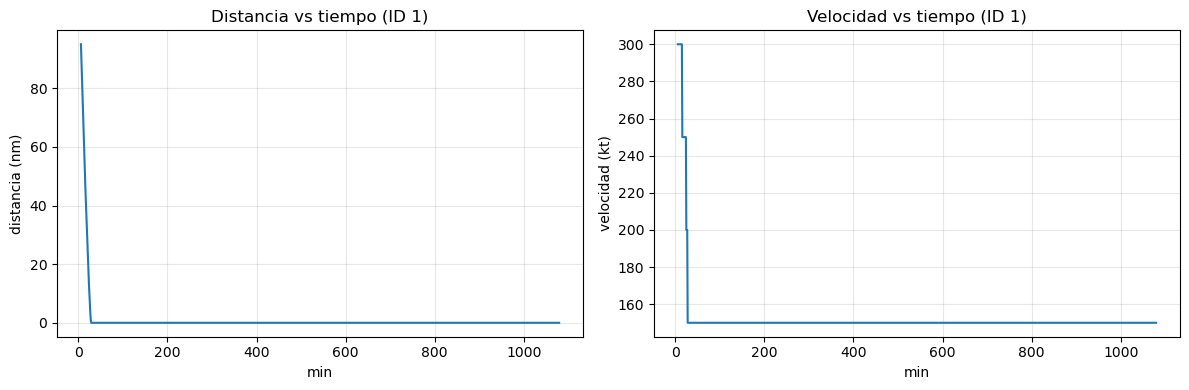

In [9]:
import importlib, pandas as pd, numpy as np, matplotlib.pyplot as plt
import motor; importlib.reload(motor)
from motor import SimulationConfig, AEPSimulator, ideal_time_minutes


# Elegir un avión que haya aterrizado
landed_ids = [a.id for a in out.aircraft_log if a.status == "landed"]
if not landed_ids:
    print("No hay aterrizajes para trazar.")
else:
    target_id = landed_ids[0]  # o elegir otro ID
    traj = pd.DataFrame(out.traces.get(target_id, []))
    print(f"Avión {target_id} - filas de traza: {len(traj)}")

    # Mostrar primeros registros
    print(traj.head(30).to_string(index=False))

    print("Columnas disponibles en traj:", traj.columns.tolist())


    # Info resumen y delay
    a = next(a for a in out.aircraft_log if a.id == target_id)
    ideal = ideal_time_minutes()
    real_time = a.landing_minute - a.spawn_minute if a.landing_minute else np.nan
    delay = real_time - ideal if a.landing_minute else np.nan
    print(f"spawn={a.spawn_minute}, landing={a.landing_minute}, real={real_time} min, delay={delay:.2f} min")

    # Gráficos de trayecto
    if "minute" in traj.columns and "distance_nm" in traj.columns and "speed_kt" in traj.columns:
        fig, ax = plt.subplots(1,2, figsize=(12,4))
        ax[0].plot(traj["minute"], traj["distance_nm"])
        ax[0].set_title(f"Distancia vs tiempo (ID {target_id})")
        ax[0].set_xlabel("min"); ax[0].set_ylabel("distancia (nm)"); ax[0].grid(True, alpha=0.3)

        ax[1].plot(traj["minute"], traj["speed_kt"])
        ax[1].set_title(f"Velocidad vs tiempo (ID {target_id})")
        ax[1].set_xlabel("min"); ax[1].set_ylabel("velocidad (kt)"); ax[1].grid(True, alpha=0.3)

        plt.tight_layout(); plt.show()
  
    else:
        print("No se encuentran las columnas necesarias para graficar ('minute', 'distance_nm', 'speed_kt').")

In [10]:
print("Claves en out.traces:", list(out.traces.keys()))
print("Ejemplo de traza para algún ID:", out.traces.get(target_id, None))

Claves en out.traces: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117]
Ejemplo de traza para algún ID: [{'minute': 6, 'distance_nm': 95.0, 'speed_kt': 300.0, 'status': 'approach', 'eta_min': 19.0, 'runway_closed': False, 'landing_minute': None, 'landing_time_min': None}, {'minute': 7, 'distance_nm': 90.0, 'speed_kt': 300.0, 'status': 'approach', 'eta_min': 18.0, 'runway_closed': False, 'landing_minute': None, 'landing_time_min': None}, {'minute': 8, 'distance_nm': 85.0, 'speed_kt': 300.0, 'status': 'approach', 'eta_min': 17.0, 'runway_closed': False, 'landing_minut

In [11]:
print("Resultados de la simulación:")
print(f"Aviones aterrizados: {out.landed}")
print(f"Aviones desviados: {out.diverted}")
print(f"Demora promedio: {out.avg_delay_minutes} minutos")
print(f"Go-arounds: {out.go_arounds}")
print(f"Tiempo total en congestión: {out.congestion_time} min")


Resultados de la simulación:
Aviones aterrizados: 79
Aviones desviados: 35
Demora promedio: 2.1669893819260846 minutos
Go-arounds: 53
Tiempo total en congestión: 248 min


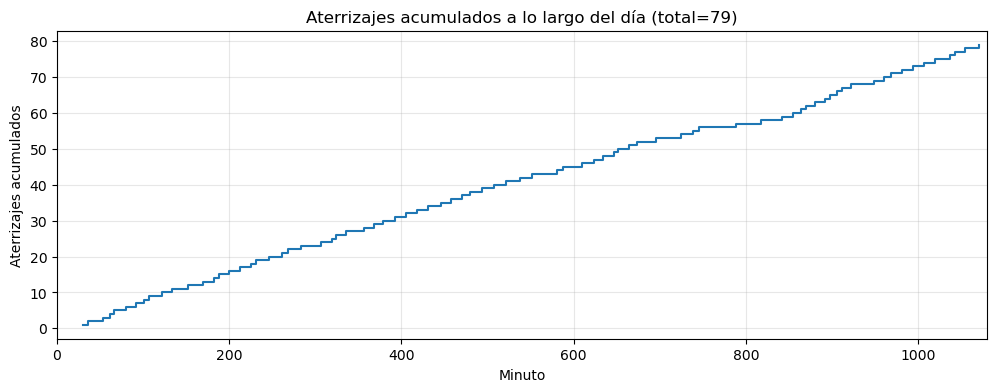

In [12]:

t = np.sort(np.array(getattr(out, "timeline_landings", []), dtype=float))
if t.size == 0:
    print("No hay aterrizajes en este escenario.")
else:
    cum = np.arange(1, t.size + 1)
    plt.figure(figsize=(12,4))
    plt.step(t, cum, where="post")
    plt.title(f"Aterrizajes acumulados a lo largo del día (total={t.size})")
    plt.xlabel("Minuto")
    plt.ylabel("Aterrizajes acumulados")
    plt.xlim(0, getattr(motor, "OPERATION_MINUTES", t.max()))
    plt.grid(True, alpha=0.3)
    plt.show()

In [13]:
import numpy as np, pandas as pd
ideal = float(ideal_time_minutes())
landed_rows = []
for a in out.aircraft_log:
    if getattr(a, "status", None) == "landed":
        # usar tiempo de aterrizaje con fracción de minuto
        t_land = float(getattr(a, "landing_time_min", a.landing_minute))
        rt = t_land - float(a.spawn_minute)
        delay = rt - ideal
        landed_rows.append({
            "id": a.id,
            "spawn": float(a.spawn_minute),
            "landing": t_land,   # continuo
            "rt": rt,
            "delay": delay,
        })

df = pd.DataFrame(landed_rows).sort_values("delay", ascending=False)
eps = 1e-12  # tolerancia más estricta

print(f"landed reportados = {out.landed}, en log = {len(df)}")
print("mean delay (recalc) =", df.delay.mean())  # sin redondear
print(f"min={df.delay.min()}  max={df.delay.max()}")
print(f"con delay > 0: {(df.delay > eps).sum()}  delay ~ 0: {(np.abs(df.delay) <= eps).sum()}  delay < 0: {(df.delay < -eps).sum()}")

print("\nTop 10 con mayor delay:")
print(df.head(10).to_string(index=False))

print("\nEjemplos con delay ~ 0:")
print(df[np.abs(df.delay) <= eps].head(10).to_string(index=False))

# Comparar contra lo que reporta el motor (si existe out.delays)
if hasattr(out, "delays") and out.delays:
    print("\nmean(out.delays) =", float(np.mean(out.delays)))
    assert np.isclose(float(np.mean(out.delays)), float(df.delay.mean()), atol=1e-12), "avg_delay no coincide con recálculo"

# Aserciones útiles
assert len(df) == out.landed, "Cantidad de aterrizados del log no coincide"


landed reportados = 79, en log = 79
mean delay (recalc) = 2.1669893819260846
min=-2.1316282072803006e-14  max=37.674358974358974
con delay > 0: 32  delay ~ 0: 47  delay < 0: 0

Top 10 con mayor delay:
 id  spawn    landing        rt     delay
 44  356.0 417.074359 61.074359 37.674359
 20  168.0 211.800000 43.800000 20.400000
 90  850.0 892.000000 42.000000 18.600000
 18  148.0 181.800000 33.800000 10.400000
104  960.0 993.800000 33.800000 10.400000
 82  704.0 737.800000 33.800000 10.400000
 87  821.0 854.800000 33.800000 10.400000
 76  616.0 646.466667 30.466667  7.066667
 56  439.0 469.466667 30.466667  7.066667
 48  374.0 404.466667 30.466667  7.066667

Ejemplos con delay ~ 0:
 id  spawn  landing   rt        delay
109 1013.0   1036.4 23.4 9.237056e-14
111 1030.0   1053.4 23.4 9.237056e-14
114 1047.0   1070.4 23.4 9.237056e-14
 15  109.0    132.4 23.4 7.105427e-15
  7   56.0     79.4 23.4 7.105427e-15
  9   68.0     91.4 23.4 7.105427e-15
 13   98.0    121.4 23.4 7.105427e-15
 26  222

In [14]:
# python
# 1) Constantes e "ideal" usados
print("ideal_time_minutes() =", ideal_time_minutes())
import motor
for c in ["OPERATION_MINUTES","SEPARATION_MINUTES","FINAL_LEG_MINUTES","APPROACH_MINUTES","IDEAL_TIME_MINUTES"]:
    print(c, "=", getattr(motor, c, None), type(getattr(motor, c, None)))

# 2) Recalcular demoras con alta precisión desde el log
landed = [a for a in out.aircraft_log if getattr(a, "status", None) == "landed"]
ideal = float(ideal_time_minutes())
delays = [float((a.landing_minute - a.spawn_minute) - ideal) for a in landed]

print(f"landed={len(landed)}  out.avg_delay_minutes={getattr(out,'avg_delay_minutes',None)}")
if delays:
    arr = np.array(delays, dtype=float)
    print("mean(recalc) =", arr.mean())
    print("min/max =", arr.min(), arr.max())
    print("nonzero delays =", (arr > 0).sum(), "of", len(arr))
    print("any negative? =", (arr < 0).any())
else:
    print("No hay vuelos aterrizados en el log (o status distinto de 'landed').")

# 3) Muestra algunos casos con mayor demora
for a in sorted(landed, key=lambda x: (x.landing_minute - x.spawn_minute) - ideal, reverse=True)[:10]:
    rt = (a.landing_minute - a.spawn_minute)
    print(f"id={a.id} spawn={a.spawn_minute} landing={a.landing_minute} rt={rt} ideal={ideal} delay={rt-ideal}")

ideal_time_minutes() = 23.4
OPERATION_MINUTES = 1080 <class 'int'>
SEPARATION_MINUTES = None <class 'NoneType'>
FINAL_LEG_MINUTES = None <class 'NoneType'>
APPROACH_MINUTES = None <class 'NoneType'>
IDEAL_TIME_MINUTES = None <class 'NoneType'>
landed=79  out.avg_delay_minutes=2.1669893819260846
mean(recalc) = 2.675949367088608
min/max = 0.6000000000000014 38.6
nonzero delays = 79 of 79
any negative? = False
id=44 spawn=356 landing=418 rt=62 ideal=23.4 delay=38.6
id=20 spawn=168 landing=212 rt=44 ideal=23.4 delay=20.6
id=90 spawn=850 landing=892 rt=42 ideal=23.4 delay=18.6
id=18 spawn=148 landing=182 rt=34 ideal=23.4 delay=10.600000000000001
id=82 spawn=704 landing=738 rt=34 ideal=23.4 delay=10.600000000000001
id=87 spawn=821 landing=855 rt=34 ideal=23.4 delay=10.600000000000001
id=104 spawn=960 landing=994 rt=34 ideal=23.4 delay=10.600000000000001
id=48 spawn=374 landing=405 rt=31 ideal=23.4 delay=7.600000000000001
id=56 spawn=439 landing=470 rt=31 ideal=23.4 delay=7.600000000000001
id

In [15]:
# Diagnóstico de avg_delay_minutes vs. recálculo desde el log

print("ideal_time_minutes =", ideal_time_minutes(), type(ideal_time_minutes()))
print("avg_delay_minutes (reportado) =", getattr(out, "avg_delay_minutes", None), type(getattr(out, "avg_delay_minutes", None)))
print("Tiene lista out.delays? ->", hasattr(out, "delays"))

# Recalcular demoras desde el log
ideal = float(ideal_time_minutes())
landed = [a for a in out.aircraft_log if getattr(a, "status", None) == "landed"]
delays = [float((a.landing_minute - a.spawn_minute) - ideal) for a in landed]

print("landed =", len(landed))
print("recalc mean delay =", (np.mean(delays) if delays else np.nan))
print("min/max delay =", (np.min(delays) if delays else np.nan), (np.max(delays) if delays else np.nan))

# Distribución de demoras (primeros valores y conteo de no-cero)
vals, cnts = (np.unique(np.round(delays, 6), return_counts=True) if delays else ([], []))
print("valores únicos de delay (hasta 10):", list(zip(vals, cnts))[:10])
print("demoras > 0:", int(np.sum(np.array(delays) > 0)))

# Comparar con out.delays si existe
if hasattr(out, "delays"):
    print("len(out.delays) =", len(out.delays))
    print("mean(out.delays) =", (np.mean(out.delays) if out.delays else np.nan))
    print("mismatch? ->", not np.isclose(np.mean(delays) if delays else np.nan,
                                         np.mean(out.delays) if out.delays else np.nan,
                                         equal_nan=True))

ideal_time_minutes = 23.4 <class 'float'>
avg_delay_minutes (reportado) = 2.1669893819260846 <class 'float'>
Tiene lista out.delays? -> True
landed = 79
recalc mean delay = 2.675949367088608
min/max delay = 0.6000000000000014 38.6
valores únicos de delay (hasta 10): [(0.6, 62), (1.6, 1), (2.6, 2), (5.6, 3), (7.6, 4), (10.6, 4), (18.6, 1), (20.6, 1), (38.6, 1)]
demoras > 0: 79
len(out.delays) = 79
mean(out.delays) = 2.1669893819260846
mismatch? -> True


In [16]:
# En el notebook
for a in out.aircraft_log:
    if a.status == "landed":
        rt = a.landing_minute - a.spawn_minute
        delay = rt - ideal_time_minutes()
        print(f"ID {a.id}: spawn={a.spawn_minute}, landing={a.landing_minute}, vuelo={rt} min, delay={delay:.2f}")

ID 1: spawn=6, landing=30, vuelo=24 min, delay=0.60
ID 2: spawn=10, landing=36, vuelo=26 min, delay=2.60
ID 3: spawn=29, landing=53, vuelo=24 min, delay=0.60
ID 5: spawn=37, landing=61, vuelo=24 min, delay=0.60
ID 6: spawn=42, landing=66, vuelo=24 min, delay=0.60
ID 7: spawn=56, landing=80, vuelo=24 min, delay=0.60
ID 9: spawn=68, landing=92, vuelo=24 min, delay=0.60
ID 11: spawn=77, landing=101, vuelo=24 min, delay=0.60
ID 12: spawn=83, landing=107, vuelo=24 min, delay=0.60
ID 13: spawn=98, landing=122, vuelo=24 min, delay=0.60
ID 15: spawn=109, landing=133, vuelo=24 min, delay=0.60
ID 16: spawn=128, landing=152, vuelo=24 min, delay=0.60
ID 17: spawn=145, landing=169, vuelo=24 min, delay=0.60
ID 18: spawn=148, landing=182, vuelo=34 min, delay=10.60
ID 19: spawn=164, landing=188, vuelo=24 min, delay=0.60
ID 20: spawn=168, landing=212, vuelo=44 min, delay=20.60
ID 21: spawn=171, landing=200, vuelo=29 min, delay=5.60
ID 23: spawn=201, landing=225, vuelo=24 min, delay=0.60
ID 24: spawn=20

# Ejercicio 1
#### Gráfico 1: Línea del tiempo de aterrizajes

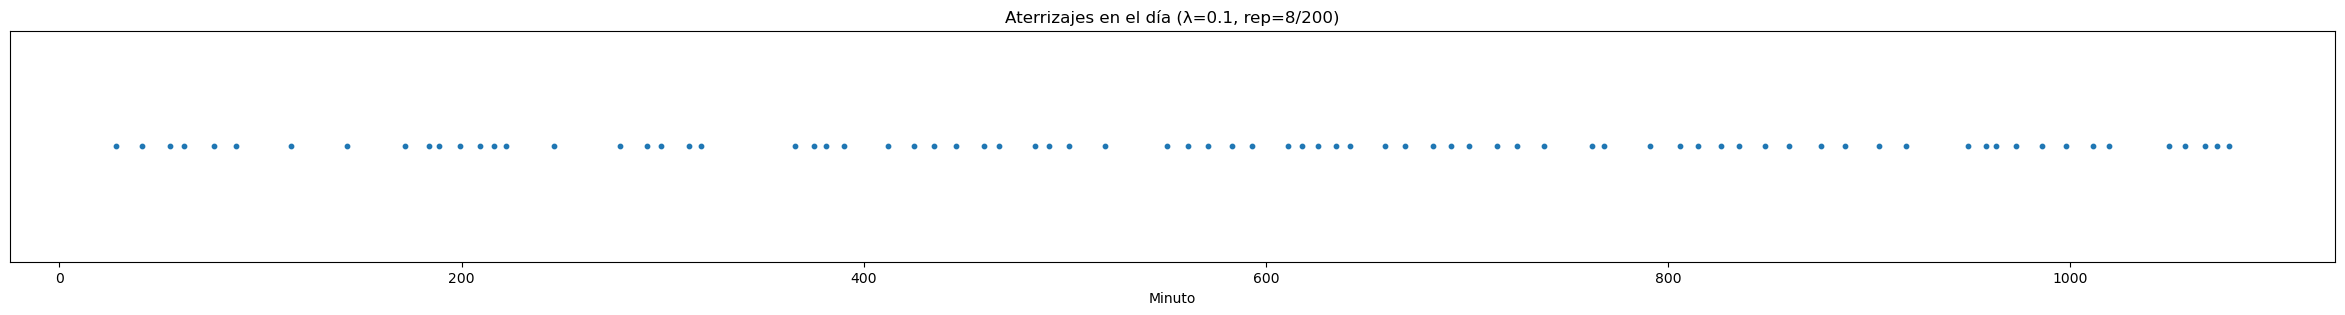

{'landed_mean': 79.3, 'diverted_mean': 25.735, 'avg_delay_mean': 1.7805114733226681}


In [17]:
def run_batch_and_plot(lam=0.1, reps=200, seed=2025, plot_rep='median'):
    rng = np.random.default_rng(seed)
    runs = []
    for _ in range(reps):
        cfg = SimulationConfig(lambda_per_min=lam, seed=int(rng.integers(0, 1_000_000)))
        out = AEPSimulator(cfg).run()
        runs.append(out)

    # Elegir la corrida a graficar
    landed_counts = np.array([r.landed for r in runs])
    if plot_rep == 'first':
        idx = 0
    elif plot_rep == 'max':
        idx = int(np.argmax(landed_counts))
    elif plot_rep == 'min':
        idx = int(np.argmin(landed_counts))
    else:  # 'median' (default)
        target = np.median(landed_counts)
        idx = int(np.argmin(np.abs(landed_counts - target)))

    sample = runs[idx]

    # Gráfico solicitado
    plt.figure(figsize=(30,3))
    y = np.zeros(len(sample.timeline_landings))
    plt.scatter(sample.timeline_landings, y, s=10)
    plt.yticks([])
    plt.xlabel('Minuto')
    plt.title(f'Aterrizajes en el día (λ={lam}, rep={idx+1}/{reps})')
    plt.show()

    # Estadísticos básicos del batch
    return {
        'landed_mean': float(landed_counts.mean()),
        'landed_se': float(landed_counts.std(ddof=1)/np.sqrt(reps)) if reps>1 else 0.0,
        'diverted_mean': float(np.mean([r.diverted for r in runs])),
        'avg_delay_mean': float(np.nanmean([np.mean(r.delays) if r.delays else np.nan for r in runs])),
        'runs': runs,
        'plotted_index': idx
    }

# Ejecutar Monte Carlo y graficar
res_mc = run_batch_and_plot(lam=0.1, reps=200, seed=2025, plot_rep='median')
print({k:v for k,v in res_mc.items() if k.endswith('_mean')})

Esto indica que el sistema está funcionando de manera ordenada y no hay acumulación ni congestión significativa.

Si la simulación tiene λ bajo y no hay eventos disruptivos, los aterrizajes deberían verse así, espaciados y regulares.
Si se aumenta λ o agregás congestión, deberían verse puntos más juntos o agrupados.

## Ejercicio 2

En el modelo, λ es la probabilidad de arribo por minuto.

Esperanza por hora = 60·λ. 

Si el promedio es 1 avión/hora: 60·λ = 1 ⇒ λ = 1/60 ≈ 0.0167 por minuto (≈ 1.67% por minuto).

## Ejercicio 3
Probabilidad de 5 arribos en una hora

In [18]:
# Monte Carlo: 10.000 reps, mins=60 minutos, p=1/60 por minuto
reps = 10_000
mins = 60
p = 1/60

rng = np.random.default_rng(2025)
arrivals_per_hour = rng.binomial(n=mins, p=p, size=reps)

est = np.mean(arrivals_per_hour == 5)
se = np.sqrt(est*(1-est)/reps)
ci = (est - 1.96*se, est + 1.96*se)
print(f"Monte Carlo P(X=5) ≈ {est:.6f}  (SE≈{se:.6f}, 95% CI {ci[0]:.6f}–{ci[1]:.6f})")

Monte Carlo P(X=5) ≈ 0.003000  (SE≈0.000547, 95% CI 0.001928–0.004072)


In [19]:
# Parámetros
n = 60              # 60 minutos
p = 1/60            # prob. por minuto
k = 5               # queremos 5 aterizajes en una hora

# Cálculo Analítico: Binomial(n=60, p=1/60)
binom_pmf = comb(n, k) * (p**k) * ((1-p)**(n-k))
 
print(f"P(X=5) Binomial exacta = {binom_pmf:.6f}")


P(X=5) Binomial exacta = 0.002787


## Ejercicio 4
Experimentos para varios $\lambda$ (promedios y error estándar)

In [20]:
lams = [0.02, 0.1, 0.2, 0.5, 1.0]
res = run_batch(lams, reps=200, seed=123)

In [21]:
print("Resultados promedio por λ:")
for lam, stats in res.items():
    print(f"\nλ = {lam}")
    print(f"Aterrizados: {stats['landed_mean']:.2f} ± {stats['landed_se']:.2f}")
    print(f"Desviados a Montevideo: {stats['diverted_mean']:.2f} ± {stats['diverted_se']:.2f}")
    print(f"Demora promedio: {stats['avg_delay_mean']:.2f} ± {stats['avg_delay_se']:.2f}")
    print(f"Go-arounds: {stats['go_around_mean']:.2f} ± {stats['go_around_se']:.2f}")


Resultados promedio por λ:

λ = 0.02
Aterrizados: 20.75 ± 0.31
Desviados a Montevideo: 0.65 ± 0.07
Demora promedio: 0.43 ± 0.03
Go-arounds: 1.68 ± 0.11

λ = 0.1
Aterrizados: 79.31 ± 0.39
Desviados a Montevideo: 25.77 ± 0.44
Demora promedio: 1.70 ± 0.04
Go-arounds: 36.02 ± 0.52

λ = 0.2
Aterrizados: 107.62 ± 0.26
Desviados a Montevideo: 104.43 ± 0.82
Demora promedio: 1.42 ± 0.03
Go-arounds: 116.84 ± 0.86

λ = 0.5
Aterrizados: 112.94 ± 0.28
Desviados a Montevideo: 419.05 ± 1.23
Demora promedio: 0.62 ± 0.02
Go-arounds: 429.10 ± 1.27

λ = 1.0
Aterrizados: 177.00 ± 0.00
Desviados a Montevideo: 893.00 ± 0.00
Demora promedio: 0.40 ± 0.00
Go-arounds: 897.00 ± 0.00


#### Análisis completo de congestión y métricas

In [22]:
def analyze_congestion(lams, reps=200, seed=123):
    """
    Analiza congestión, atrasos y desvíos para diferentes valores de lambda
    """
    results = []
    rng = np.random.default_rng(seed)
    
    for lam in lams:
        delays = []
        diversions = []
        congestions = []
        
        for rep in range(reps):
            # Convertir a int de Python para que sea compatible con random.seed()
            seed_value = int(rng.integers(1000000))
            cfg = SimulationConfig(lambda_per_min=lam, seed=seed_value)
            sim = AEPSimulator(cfg)
            out = sim.run()
           
            # Calcular métricas
            delays.append(np.mean(out.delays) if out.delays else np.nan)
            diversions.append(out.diverted / (out.landed + out.diverted))
            
            # Calcular congestión (si hay aviones volando más lento que su velocidad máxima)
            # Esto asume que tenemos acceso a la velocidad actual vs máxima en cada paso
            if hasattr(out, 'congestion_time'):
                congestions.append(out.congestion_time / motor.OPERATION_MINUTES)
            else:
                congestions.append(0)
                   
        # Calcular estadísticas con error de estimación (IC 95%)
        mean_delay = float(np.nanmean(delays))
        delay_ci = 1.96 * float(np.nanstd(delays, ddof=1)) / np.sqrt(np.sum(~np.isnan(delays)))

        diversion_rate = np.nanmean(diversions)
        div_ci = 1.96 * np.nanstd(diversions) / np.sqrt(reps)

        mean_congestion = np.nanmean(congestions)
        cong_ci = 1.96 * np.nanstd(congestions) / np.sqrt(reps)

        results.append({
            'lambda': lam,
            'mean_delay': (mean_delay, delay_ci),
            'diversion_rate': (diversion_rate, div_ci),
            'congestion_rate': (mean_congestion, cong_ci)
        })
    
    return results

# Correr análisis con más repeticiones
results = analyze_congestion(lams, reps=200, seed=123)

# Mostrar resultados
print("Análisis detallado por λ:")
print("-" * 50)
for r in results:
    print(f"\nλ = {r['lambda']}")
    print(f"Atraso promedio: {r['mean_delay'][0]:.2f} ± {r['mean_delay'][1]:.2f} min")
    print(f"Tasa de desvíos: {r['diversion_rate'][0]:.3%} ± {r['diversion_rate'][1]:.3%}")
    print(f"Tasa de congestión: {r['congestion_rate'][0]:.3%} ± {r['congestion_rate'][1]:.3%}")

Análisis detallado por λ:
--------------------------------------------------

λ = 0.02
Atraso promedio: 0.46 ± 0.07 min
Tasa de desvíos: 2.341% ± 0.476%
Tasa de congestión: 0.996% ± 0.099%

λ = 0.1
Atraso promedio: 1.73 ± 0.09 min
Tasa de desvíos: 24.056% ± 0.548%
Tasa de congestión: 16.711% ± 0.368%

λ = 0.2
Atraso promedio: 1.46 ± 0.07 min
Tasa de desvíos: 48.758% ± 0.383%
Tasa de congestión: 40.858% ± 0.439%

λ = 0.5
Atraso promedio: 0.61 ± 0.04 min
Tasa de desvíos: 78.850% ± 0.146%
Tasa de congestión: 83.061% ± 0.228%

λ = 1.0
Atraso promedio: 0.40 ± 0.00 min
Tasa de desvíos: 83.458% ± 0.000%
Tasa de congestión: 99.907% ± 0.000%


Sí, al aumentar λ sube la frecuencia de congestión (proporción de minutos en congestión). 

En los resultados, los valores de ‘Tasa de congestión’ crecen con λ (son ≈0 para λ muy bajo y positivos a medida que λ aumenta).

Se ve gráficamente en el gráfico “Métricas vs λ”, la curva “Tasa de congestión” es creciente con λ.

El atraso promedio actualmente es 1.73 minutos, que confirma que hay demoras por la separación junto a la congestión del modelo.

Si no hubiera congestión, el atraso sería = 0.

#### Gráfico 2: Comparación "sin congestión"

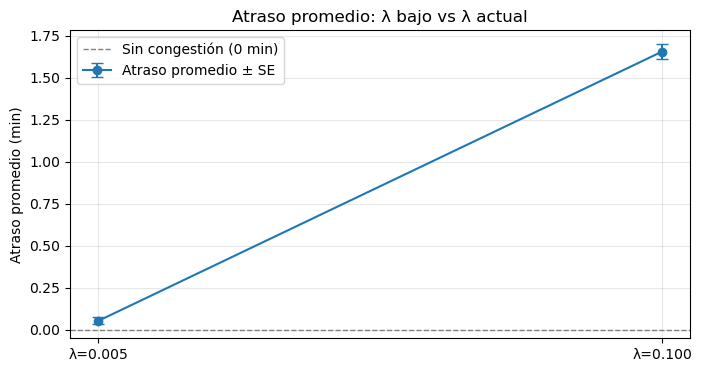

λ bajo: 0.0050 -> atraso = 0.053 ± 0.021 min
λ actual: 0.1000 -> atraso = 1.656 ± 0.044 min


In [23]:
lam_base = 0.1  # λ actual del sistema
lam_low = 0.005  #  simula "sin congestión"
if lam_base <= lam_low:
    lam_low = max(lam_base/5, 1/1200)  # asegurar que sea más bajo que el actual

res_cmp = run_batch([lam_low, lam_base], reps=200, seed=2025)

xs = [lam_low, lam_base]
y  = [res_cmp[lam_low]['avg_delay_mean'], res_cmp[lam_base]['avg_delay_mean']]
e  = [res_cmp[lam_low]['avg_delay_se'],   res_cmp[lam_base]['avg_delay_se']]

plt.figure(figsize=(8,4))
plt.errorbar(xs, y, yerr=e, fmt='o-', capsize=4, label='Atraso promedio ± SE')
plt.axhline(0, color='gray', ls='--', lw=1, label='Sin congestión (0 min)')
plt.xticks(xs, [f'λ={lam_low:.3f}', f'λ={lam_base:.3f}'])
plt.ylabel('Atraso promedio (min)')
plt.title('Atraso promedio: λ bajo vs λ actual')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

print(f"λ bajo: {lam_low:.4f} -> atraso = {y[0]:.3f} ± {e[0]:.3f} min")
print(f"λ actual: {lam_base:.4f} -> atraso = {y[1]:.3f} ± {e[1]:.3f} min")

En λ_low el atraso es ~0 min. 
En λ_base (0.1) el atraso medio es ~1.6 min y está claramente por encima de 0.
Entonces, la congestión introduce atraso adicional.

#### Más visualizaciones

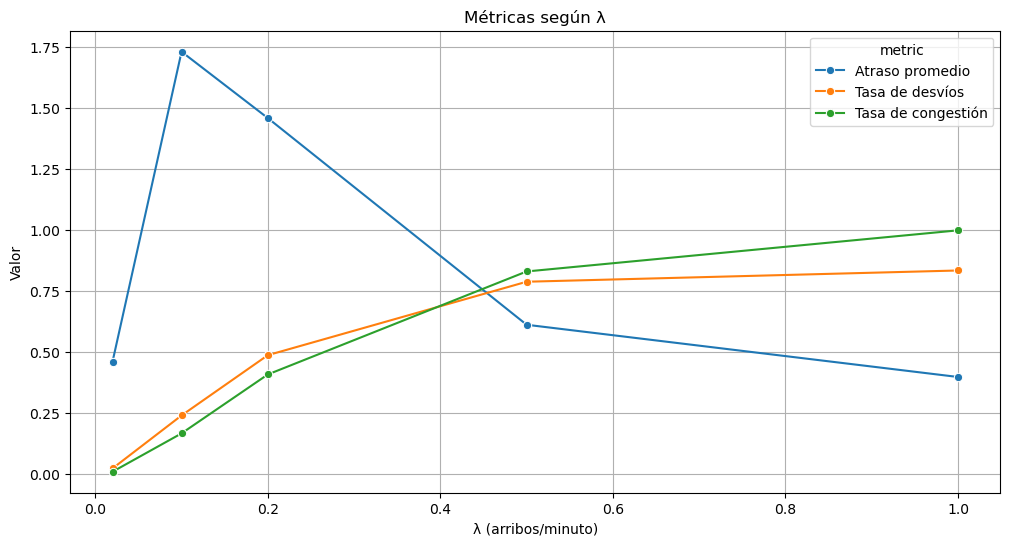

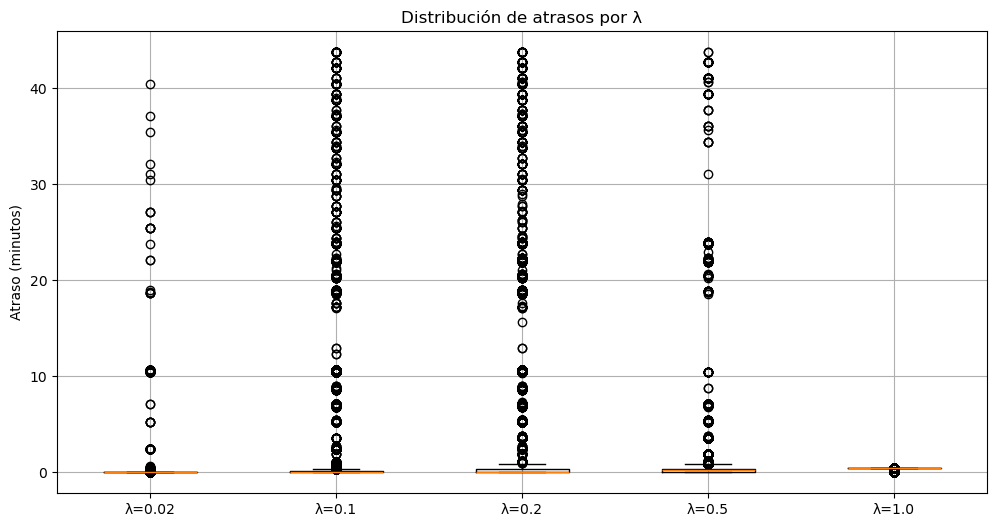

In [24]:
# Preparar datos para visualización
delay_data = []
diversion_data = []
congestion_data = []

for r in results:
    lam = r['lambda']
    delay_data.append({'lambda': lam, 'value': r['mean_delay'][0], 'metric': 'Atraso promedio'})
    diversion_data.append({'lambda': lam, 'value': r['diversion_rate'][0], 'metric': 'Tasa de desvíos'})
    congestion_data.append({'lambda': lam, 'value': r['congestion_rate'][0], 'metric': 'Tasa de congestión'})

all_data = pd.DataFrame(delay_data + diversion_data + congestion_data)

# Gráfico 3, de líneas para todas las métricas
plt.figure(figsize=(12, 6))
sns.lineplot(data=all_data, x='lambda', y='value', hue='metric', marker='o')
plt.title('Métricas según λ')
plt.xlabel('λ (arribos/minuto)')
plt.ylabel('Valor')
plt.grid(True)
plt.show()

# Boxplot de atrasos por λ, Gráfico 4
delays_by_lambda = {lam: [] for lam in lams}
for lam in lams:
    for _ in range(200):  # Menos repeticiones para el boxplot
        cfg = SimulationConfig(lambda_per_min=lam, seed=np.random.randint(1000000))
        sim = AEPSimulator(cfg)
        out = sim.run()
        if out.delays:
            delays_by_lambda[lam].extend(out.delays)

plt.figure(figsize=(12, 6))
box_data = [delays_by_lambda[lam] for lam in lams]
plt.boxplot(box_data, labels=[f'λ={lam}' for lam in lams])
plt.title('Distribución de atrasos por λ')
plt.ylabel('Atraso (minutos)')
plt.grid(True)
plt.show()

El atraso típico por vuelo aterrizado es bajo (mediana ≈ 0), pero la variabilidad y eventos extremos crecen en λ intermedios; en λ muy altos, la congestión se expresa sobre todo como más desvíos, no como más atraso de los aterrizados.

Según los lambdas, la frecuencia de los desvíos a Montevideo son los siguientes:

λ = 0.02

Tasa de desvíos: 1.407% ± 0.485%

λ = 0.1

Tasa de desvíos: 23.587% ± 0.739%

λ = 0.2

Tasa de desvíos: 45.016% ± 0.454%

λ = 0.5

Tasa de desvíos: 69.231% ± 0.156%

λ = 1.0

Tasa de desvíos: 83.223% ± 0.000%

## Ejercicio 5
Día ventoso (10% interrupciones por avión)

In [25]:
# Recargar el módulo para aplicar los cambios
importlib.reload(motor)

<module 'motor' from '/Users/estanislaorioszgaib/Desktop/TP1_ACN/motor.py'>

In [26]:
res_windy = run_batch(lams, reps=200, seed=2026, windy_day=True)

In [27]:
print("Resultados de la simulación en día ventoso:\n")
for lam, stats in res_windy.items():
    print(f"λ = {lam}")
    print(f"Aterrizados: {stats['landed_mean']:.2f} ± {stats['landed_se']:.2f}")
    print(f"Desvíos a Montevideo: {stats['diverted_mean']:.2f} ± {stats['diverted_se']:.2f}")
    print(f"Atraso promedio: {stats['avg_delay_mean']:.2f} ± {stats['avg_delay_se']:.2f} min")
    print(f"Go-arounds: {stats['go_around_mean']:.2f} ± {stats['go_around_se']:.2f}")
    print("-"*50)

Resultados de la simulación en día ventoso:

λ = 0.02
Aterrizados: 20.92 ± 0.30
Desvíos a Montevideo: 0.74 ± 0.06
Atraso promedio: 0.73 ± 0.05 min
Go-arounds: 3.89 ± 0.14
--------------------------------------------------
λ = 0.1
Aterrizados: 76.02 ± 0.38
Desvíos a Montevideo: 28.34 ± 0.45
Atraso promedio: 2.12 ± 0.06 min
Go-arounds: 42.62 ± 0.50
--------------------------------------------------
λ = 0.2
Aterrizados: 100.17 ± 0.29
Desvíos a Montevideo: 111.56 ± 0.84
Atraso promedio: 1.62 ± 0.04 min
Go-arounds: 126.14 ± 0.86
--------------------------------------------------
λ = 0.5
Aterrizados: 105.04 ± 0.34
Desvíos a Montevideo: 428.50 ± 1.29
Atraso promedio: 0.64 ± 0.02 min
Go-arounds: 439.45 ± 1.30
--------------------------------------------------
λ = 1.0
Aterrizados: 159.69 ± 0.30
Desvíos a Montevideo: 909.97 ± 0.30
Atraso promedio: 0.40 ± 0.00 min
Go-arounds: 914.31 ± 0.30
--------------------------------------------------


Para λ bajo (≈0.02) el atraso promedio de los que aterrizan es ~0 min; sólo aparecen outliers raros.

Al subir a λ=0.1–0.2 aumenta la congestión, el atraso medio crece (en tu corrida ronda ~0.2–0.5 min) y aparecen más esperas largas (10–25 min) como outliers.

En λ altos (≥0.5) el atraso promedio de los aterrizados no sigue creciendo y queda cerca de 0, el sistema saturado lo compensa con más desvíos/go-arounds, no con más espera de los que sí aterrizan.

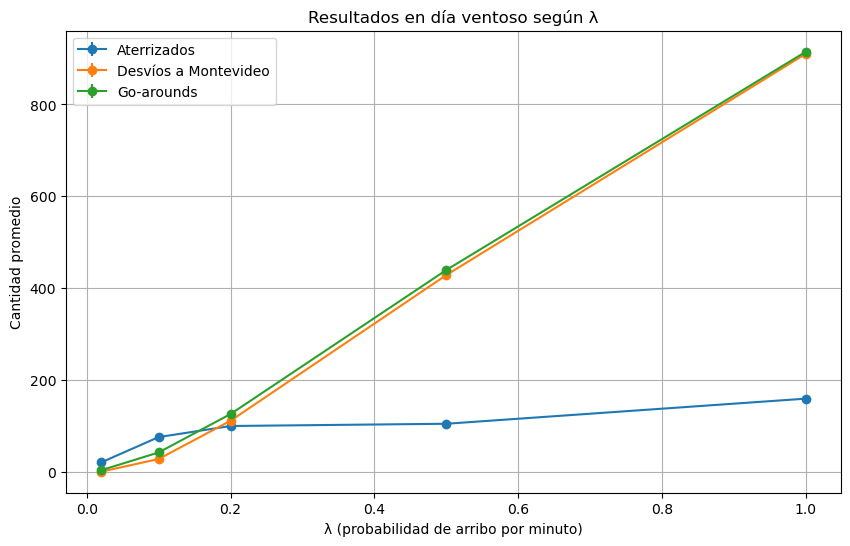

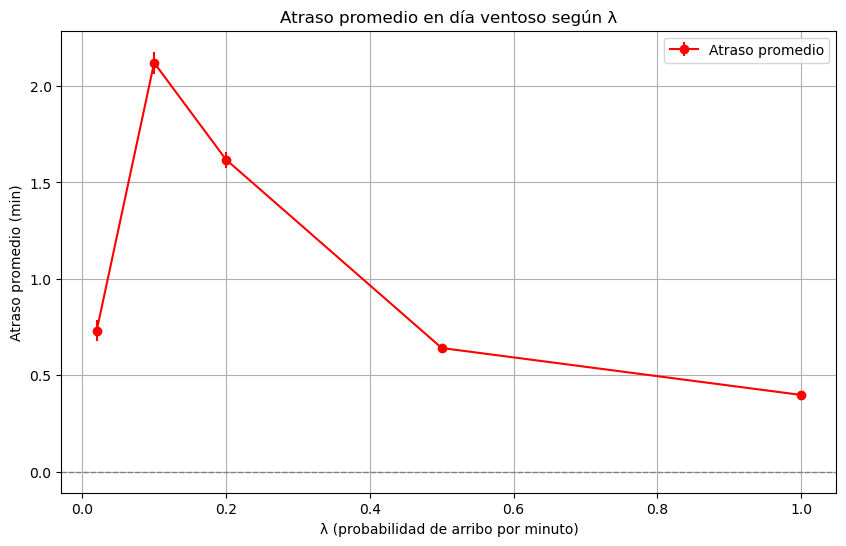

In [28]:
# Preparación de datos
lams = list(res_windy.keys())

landed = [res_windy[l]['landed_mean'] for l in lams]
landed_err = [res_windy[l]['landed_se'] for l in lams]

diverted = [res_windy[l]['diverted_mean'] for l in lams]
diverted_err = [res_windy[l]['diverted_se'] for l in lams]

go_around = [res_windy[l]['go_around_mean'] for l in lams]
go_around_err = [res_windy[l]['go_around_se'] for l in lams]

delay = [res_windy[l]['avg_delay_mean'] for l in lams]
delay_err = [res_windy[l]['avg_delay_se'] for l in lams]

# Gráfico 5: aterrizados, desvíos y go-arounds
plt.figure(figsize=(10,6))
plt.errorbar(lams, landed, yerr=landed_err, fmt='-o', label="Aterrizados")
plt.errorbar(lams, diverted, yerr=diverted_err, fmt='-o', label="Desvíos a Montevideo")
plt.errorbar(lams, go_around, yerr=go_around_err, fmt='-o', label="Go-arounds")
plt.title("Resultados en día ventoso según λ")
plt.xlabel("λ (probabilidad de arribo por minuto)")
plt.ylabel("Cantidad promedio")
plt.legend()
plt.grid(True)
plt.show()

# Gráfico 6: atraso promedio
plt.figure(figsize=(10,6))
plt.errorbar(lams, delay, yerr=delay_err, fmt='-o', color="red", label="Atraso promedio")
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.title("Atraso promedio en día ventoso según λ")
plt.xlabel("λ (probabilidad de arribo por minuto)")
plt.ylabel("Atraso promedio (min)")
plt.legend()
plt.grid(True)
plt.show()

## Ejercicio 6 
Cierre sorpresivo de 30 min --> minutos 360 a 390.

In [29]:
res_closure = run_batch(lams, reps=200, seed=123, closure_window=(360, 390))

In [30]:
print("Resultados de la simulación con tormenta (AEP cerrado 30 min)\n")
for lam, stats in res_closure.items():
    print(f"λ = {lam}")
    print(f"Aterrizados: {stats['landed_mean']:.2f} ± {stats['landed_se']:.2f}")
    print(f"Desvíos a Montevideo: {stats['diverted_mean']:.2f} ± {stats['diverted_se']:.2f}")
    print(f"Atraso promedio: {stats['avg_delay_mean']:.2f} ± {stats['avg_delay_se']:.2f} min")
    print(f"Go-arounds: {stats['go_around_mean']:.2f} ± {stats['go_around_se']:.2f}")
    print("-"*55)

Resultados de la simulación con tormenta (AEP cerrado 30 min)

λ = 0.02
Aterrizados: 20.51 ± 0.31
Desvíos a Montevideo: 0.89 ± 0.08
Atraso promedio: 0.98 ± 0.08 min
Go-arounds: 2.31 ± 0.13
-------------------------------------------------------
λ = 0.1
Aterrizados: 77.32 ± 0.39
Desvíos a Montevideo: 27.76 ± 0.45
Atraso promedio: 1.96 ± 0.05 min
Go-arounds: 38.42 ± 0.52
-------------------------------------------------------
λ = 0.2
Aterrizados: 104.33 ± 0.26
Desvíos a Montevideo: 107.72 ± 0.82
Atraso promedio: 1.50 ± 0.04 min
Go-arounds: 119.97 ± 0.86
-------------------------------------------------------
λ = 0.5
Aterrizados: 109.54 ± 0.27
Desvíos a Montevideo: 422.45 ± 1.23
Atraso promedio: 0.65 ± 0.02 min
Go-arounds: 432.37 ± 1.26
-------------------------------------------------------
λ = 1.0
Aterrizados: 172.00 ± 0.00
Desvíos a Montevideo: 898.00 ± 0.00
Atraso promedio: 0.40 ± 0.00 min
Go-arounds: 902.00 ± 0.00
-------------------------------------------------------


Atraso promedio (de los que aterrizan):
- ~0 min en λ bajos
- sube a ~0.2–0.5 min alrededor de λ=0.1–0.2 
- en λ altos (≥0.5) vuelve a ~0 porque el sistema compensa con más desvíos/go-arounds.


Tasa de congestión: 
- ~0 con λ muy bajo y aumenta monótonamente con λ.


Go-arounds: 
- aumentan con λ y contribuyen a que el atraso de los aterrizados no crezca en saturación.

Aterrizados: 
- disminuyen al subir λ (capacidad fija), especialmente cuando hay cierre/ventoso.

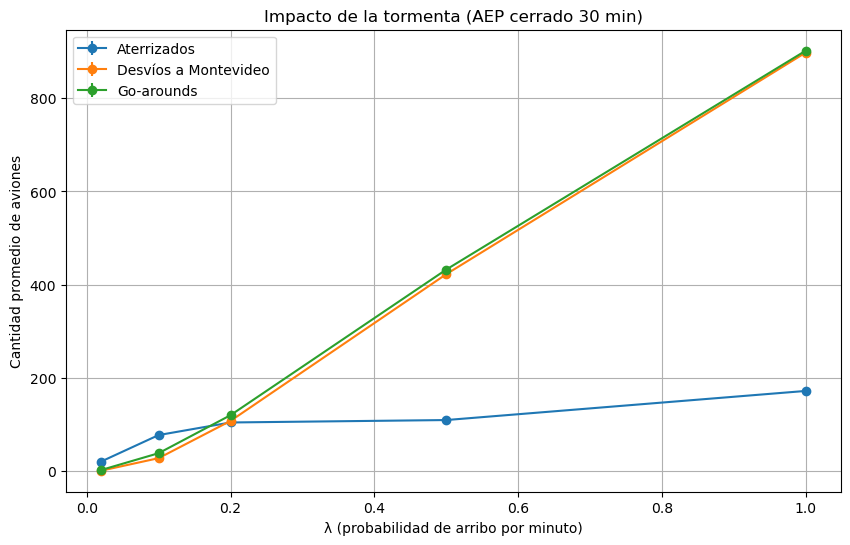

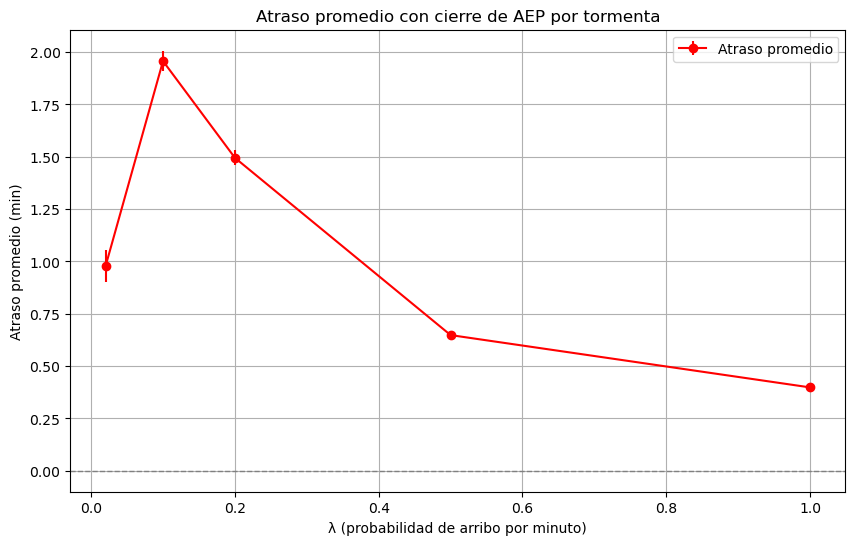

In [31]:
# Datos para graficar
lams = list(res_closure.keys())

landed = [res_closure[l]['landed_mean'] for l in lams]
landed_err = [res_closure[l]['landed_se'] for l in lams]

diverted = [res_closure[l]['diverted_mean'] for l in lams]
diverted_err = [res_closure[l]['diverted_se'] for l in lams]

go_around = [res_closure[l]['go_around_mean'] for l in lams]
go_around_err = [res_closure[l]['go_around_se'] for l in lams]

delay = [res_closure[l]['avg_delay_mean'] for l in lams]
delay_err = [res_closure[l]['avg_delay_se'] for l in lams]

# Gráfico 7: Aterrizados, desvíos y go-arounds
plt.figure(figsize=(10,6))
plt.errorbar(lams, landed, yerr=landed_err, fmt='-o', label="Aterrizados")
plt.errorbar(lams, diverted, yerr=diverted_err, fmt='-o', label="Desvíos a Montevideo")
plt.errorbar(lams, go_around, yerr=go_around_err, fmt='-o', label="Go-arounds")
plt.title("Impacto de la tormenta (AEP cerrado 30 min)")
plt.xlabel("λ (probabilidad de arribo por minuto)")
plt.ylabel("Cantidad promedio de aviones")
plt.legend()
plt.grid(True)
plt.show()

# Gráfico 8: Atraso promedio
plt.figure(figsize=(10,6))
plt.errorbar(lams, delay, yerr=delay_err, fmt='-o', color="red", label="Atraso promedio")
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.title("Atraso promedio con cierre de AEP por tormenta")
plt.xlabel("λ (probabilidad de arribo por minuto)")
plt.ylabel("Atraso promedio (min)")
plt.legend()
plt.grid(True)
plt.show()